### COVID CXR - Multi class prediction

Mounting google drive on the notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/My\ Drive/covid-cxr-njit-cs677/

/content/drive/My Drive/covid-cxr-njit-cs677


Installing required packages

In [2]:
pip install -r requirements.txt

In [3]:
cd data

/content/drive/My Drive/covid-cxr-njit-cs677/data


In [55]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


In [19]:
!git clone https://github.com/agchung/Figure1-COVID-chestxray-dataset.git

Cloning into 'Figure1-COVID-chestxray-dataset'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 112 (delta 28), reused 95 (delta 14), pack-reused 0
Receiving objects: 100% (112/112), 14.13 MiB | 14.07 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [32]:
!pip install --upgrade pip
!pip install kaggle

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)
Found existing installation: kaggle 1.5.9
Uninstalling kaggle-1.5.9:
  Would remove:
    /usr/local/bin/kaggle
    /usr/local/lib/python3.6/dist-packages/kaggle-1.5.9.dist-info/*
    /usr/local/lib/python3.6/dist-packages/kaggle/*
Proceed (y/n)? y
  Successfully uninstalled kaggle-1.5.9
     |████████████████████████████████| 58 kB 4.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.9-py3-none-any.whl size=73265 sha256=1d538bc07dc77aa4d79db3285cccf7acde91d4dfc99c63bb3659392fc754e738
  Stored in directory: /root/.cache/pip/wheels/9d/50/3d/2644504bb1e8c782f3fef5984f03d76fc4a74698fdec128b29
Successfully built kaggle


In [33]:
import os
os.environ['KAGGLE_USERNAME']="kowsick"
os.environ['KAGGLE_KEY']="84a3fa384143ba0e0be1aff863231a28"

In [37]:
%cd /content/drive/My\ Drive/covid-cxr-njit-cs677/

/content/drive/MyDrive/covid-cxr-njit-cs677


In [38]:
ROOT_DIR = os.path.abspath('./data')
ROOT_DIR

In [40]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
  os.makedirs(ROOT_DIR)
  os.chdir(ROOT_DIR)

!kaggle --version

Download data sets from Kaggle via Kaggle API

In [42]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge --force

100% 3.66G/3.66G [01:22<00:00, 100MB/s] 
100% 3.66G/3.66G [01:22<00:00, 47.4MB/s]


Unzip Kaggle dataset

In [43]:
!unzip rsna-pneumonia-detection-challenge -d data/rsna
%cd ..

Streaming output truncated to the last 5000 lines.
  inflating: rsna/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: rsna/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: rsna/stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: rsna/stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: rsna/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: rsna/stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: rsna/stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: rsna/stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: rsna/stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: rsna/stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: rsna/stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: rsna/stage_2_train_images/d539e101

# Execute Pre-Process.py

In [25]:
%cd /content/drive/My\ Drive/covid-cxr-njit-cs677/

/content/drive/My Drive/covid-cxr-njit-cs677


In [26]:
import numpy as np
import pandas as pd
import pydicom as dicom
import yaml
import os
import pathlib
import shutil
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split


def build_dataset(cfg):
    '''
    Build a dataset of filenames and labels according to the type of classification
    :param cfg: Project config dictionary
    :return: DataFrame of file names of examples and corresponding class labels
    '''

    # Get paths of raw datasets to be included
    mila_data_path = cfg['PATHS']['MILA_DATA']
    fig1_data_path = cfg['PATHS']['FIGURE1_DATA']
    rsna_data_path = cfg['PATHS']['RSNA_DATA']

    # Assemble filenames comprising Mila dataset
    mila_df = pd.read_csv(mila_data_path + 'metadata.csv')
    mila_df['filename'] = mila_data_path.split('/')[-2] + '/images/' + mila_df['filename'].astype(str)
    mila_views_cxrs_df = (mila_df['view'].str.contains('|'.join(cfg['DATA']['VIEWS'])))    # Select desired X-ray views
    mila_covid_pts_df = (mila_df['finding'] == 'COVID-19')
    mila_covid_views_df = mila_df[mila_covid_pts_df & mila_views_cxrs_df]  # Images for patients diagnosed with COVID-19

    # Assemble filenames comprising Figure 1 dataset
    fig1_df = pd.read_csv(fig1_data_path + 'metadata.csv', encoding='ISO-8859-1')
    fig1_df['filename'] = ''
    for i, row in fig1_df.iterrows():
        if os.path.exists(fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.jpg'):
            fig1_df.loc[i, 'filename'] = fig1_data_path.split('/')[-2] + '/images/' + fig1_df.loc[i, 'patientid'] + '.jpg'
        else:
            fig1_df.loc[i, 'filename'] = fig1_data_path.split('/')[-2] + '/images/' + fig1_df.loc[i, 'patientid'] + '.png'
    fig1_df['view'].fillna('PA or AP', inplace=True)    # All images in this dataset are either AP or PA
    fig1_views_cxrs_df = (fig1_df['view'].str.contains('|'.join(cfg['DATA']['VIEWS'])))    # Select desired X-ray views
    fig1_covid_pts_df = (fig1_df['finding'] == 'COVID-19')
    fig1_covid_views_df = fig1_df[fig1_covid_pts_df & fig1_views_cxrs_df]  # Images for patients diagnosed COVID-19

    # Assemble filenames comprising RSNA dataset
    rsna_metadata_path = rsna_data_path + 'stage_2_train_labels.csv'
    rsna_df = pd.read_csv(rsna_metadata_path)
    num_rsna_imgs = cfg['DATA']['NUM_RSNA_IMGS']
    rsna_normal_df = rsna_df[rsna_df['Target'] == 0]
    rsna_pneum_df = rsna_df[rsna_df['Target'] == 1]

    # Convert dicom files of CXRs with no findings to jpg if not done already in a previous run. Select desired views.
    file_counter = 0
    normal_idxs = []
    for df_idx in rsna_normal_df.index.values.tolist():
        filename = rsna_normal_df.loc[df_idx]['patientId']
        ds = dicom.dcmread(os.path.join(rsna_data_path + 'stage_2_train_images/' + filename + '.dcm'))
        if any(view in ds.SeriesDescription.split(' ')[1] for view in cfg['DATA']['VIEWS']):  # Select desired X-ray views
            if not os.path.exists(rsna_data_path + filename + '.jpg'):
                cv2.imwrite(os.path.join(rsna_data_path + filename + '.jpg'), ds.pixel_array)   # Save as .jpg
            normal_idxs.append(df_idx)
            file_counter += 1
        if file_counter >= num_rsna_imgs // 2:
            break
    rsna_normal_df = rsna_normal_df.loc[normal_idxs]

    # Convert dicom files of CXRs with pneumonia to jpg if not done already in a previous run. Select desired views.
    file_counter = 0
    pneum_idxs = []
    num_remaining = num_rsna_imgs - num_rsna_imgs // 2
    for df_idx in rsna_pneum_df.index.values.tolist():
        filename = rsna_pneum_df.loc[df_idx]['patientId']
        ds = dicom.dcmread(os.path.join(rsna_data_path + 'stage_2_train_images/' + filename + '.dcm'))
        if any(view in ds.SeriesDescription.split(' ')[1] for view in cfg['DATA']['VIEWS']):  # Select desired X-ray views
            if not os.path.exists(rsna_data_path + filename + '.jpg'):
                cv2.imwrite(os.path.join(rsna_data_path + filename + '.jpg'), ds.pixel_array)  # Save as .jpg
            pneum_idxs.append(df_idx)
            file_counter += 1
        if file_counter >= num_remaining:
            break
    rsna_pneum_df = rsna_pneum_df.loc[pneum_idxs]

    mode = cfg['TRAIN']['CLASS_MODE']
    n_classes = len(cfg['DATA']['CLASSES'])
    class_dict = {cfg['DATA']['CLASSES'][i]: i for i in range(n_classes)}  # Map class name to number
    label_dict = {i: cfg['DATA']['CLASSES'][i] for i in range(n_classes)}  # Map class name to number

    if mode == 'binary':
        mila_covid_views_df['label'] = 1                                       # Mila images with COVID-19 diagnosis
        mila_other_views_df = mila_df[~mila_covid_pts_df & mila_views_cxrs_df]
        mila_other_views_df['label'] = 0                                       # Mila images with alternative diagnoses
        fig1_covid_views_df['label'] = 1                                       # Figure 1 images with COVID-19 diagnosis
        file_df = pd.concat([mila_covid_views_df[['filename', 'label']], mila_other_views_df[['filename', 'label']],
                             fig1_covid_views_df[['filename', 'label']]], axis=0)

        rsna_df = pd.concat([rsna_normal_df, rsna_pneum_df], axis=0)
        rsna_filenames = rsna_data_path.split('/')[-2] + '/' + rsna_df['patientId'].astype(str) + '.jpg'
        rsna_file_df = pd.DataFrame({'filename': rsna_filenames, 'label': 0})

        file_df = pd.concat([file_df, rsna_file_df], axis=0)         # Combine both datasets
    else:
        mila_covid_views_df['label'] = class_dict['COVID-19']
        mila_views_pneum_df = mila_df[mila_df['finding'].isin(['SARS', 'Steptococcus', 'MERS', 'Legionella', 'Klebsiella',
                                                            'Chlamydophila', 'Pneumocystis']) & mila_views_cxrs_df]
        mila_views_pneum_df['label'] = class_dict['other_pneumonia']                 # Mila CXRs with other peumonias
        mila_views_normal_df = mila_df[mila_df['finding'].isin(['No finding']) & mila_views_cxrs_df]
        mila_views_normal_df['label'] = class_dict['normal']                         # Mila CXRs with no finding
        fig1_covid_views_df['label'] = class_dict['COVID-19']                        # Figure 1 CXRs with COVID-19 finding
        file_df = pd.concat([mila_covid_views_df[['filename', 'label']], mila_views_pneum_df[['filename', 'label']],
                             mila_views_normal_df[['filename', 'label']], fig1_covid_views_df[['filename', 'label']]], axis=0)

        # Organize some files from RSNA dataset into "normal", and "pneumonia" XRs
        rsna_normal_filenames = rsna_data_path.split('/')[-2] + '/' + rsna_normal_df['patientId'].astype(str) + '.jpg'
        rsna_pneum_filenames = rsna_data_path.split('/')[-2] + '/' + rsna_pneum_df['patientId'].astype(str) + '.jpg'
        rsna_normal_file_df = pd.DataFrame({'filename': rsna_normal_filenames, 'label': class_dict['normal']})
        rsna_pneum_file_df = pd.DataFrame({'filename': rsna_pneum_filenames, 'label': class_dict['other_pneumonia']})
        rsna_file_df = pd.concat([rsna_normal_file_df, rsna_pneum_file_df], axis=0)

        file_df = pd.concat([file_df, rsna_file_df], axis=0)  # Combine both datasets

    file_df['label_str'] = file_df['label'].map(label_dict) # Add column for string representation of label
    return file_df


def remove_text(img):
    '''
    Attempts to remove bright textual artifacts from X-ray images. For example, many images indicate the right side of
    the body with a white 'R'. Works only for very bright text.
    :param img: Numpy array of image
    :return: Array of image with (ideally) any characters removed and inpainted
    '''
    mask = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)[1][:, :, 0].astype(np.uint8)
    img = img.astype(np.uint8)
    result = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS).astype(np.float32)
    return result


def preprocess(cfg=None):
    '''
    Preprocess and partition image data. Assemble all image file paths and partition into training, validation and
    test sets. Copy raw images to folders for training, validation and test sets.
    :param cfg: Optional parameter to set your own config object.
    '''

    if cfg is None:
        cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))  # Load config data

    # Build dataset based on type of classification
    file_df = build_dataset(cfg)

    # Split dataset into train, val and test sets
    val_split = cfg['DATA']['VAL_SPLIT']
    test_split = cfg['DATA']['TEST_SPLIT']
    file_df_train, file_df_test = train_test_split(file_df, test_size=test_split, stratify=file_df['label'])
    relative_val_split = val_split / (1 - test_split)  # Calculate fraction of train_df to be used for validation
    file_df_train, file_df_val = train_test_split(file_df_train, test_size=relative_val_split,
                                                      stratify=file_df_train['label'])

    # Save training, validation and test sets
    if not os.path.exists(cfg['PATHS']['PROCESSED_DATA']):
        os.makedirs(cfg['PATHS']['PROCESSED_DATA'])
    file_df_train.to_csv(cfg['PATHS']['TRAIN_SET'])
    file_df_val.to_csv(cfg['PATHS']['VAL_SET'])
    file_df_test.to_csv(cfg['PATHS']['TEST_SET'])
    return

if __name__ == '__main__':
    preprocess()  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
!python --version

Python 3.6.9


In [9]:
pip uninstall keras

Uninstalling Keras-2.4.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.4.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.4.3


# Execute Train.py

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '', '../', '', '../', '']
Train set shape before oversampling:  (848, 3)  Train set shape after resampling:  (1230, 3)
Found 1230 non-validated image filenames belonging to 3 classes.
Found 83 non-validated image filenames belonging to 3 classes.
Found 104 non-validated image filenames belonging to 3 classes.
Training distribution:  ['Class COVID-19: 410. ', 'Class normal: 410. ', 'Class other_pneumonia: 410. ']
MODEL CONFIG:  {'KERNEL_SIZE': '(3,3)', 'STRIDES': '(1,1)', 'INIT_FILTERS': 16, 'FILTER_EXP_BASE': 3, 'MAXPOOL_SIZE': '(2,2)', 'CONV_BLOCKS': 4, 'NODES_DENSE0': 128, 'LR': 0.0002, 'OPTIMIZER': 'adam', 'DROPOUT': 0.4, 'L2_LAMBDA': 0.0001}
Model: "functional_7"
____________________________________________________________________

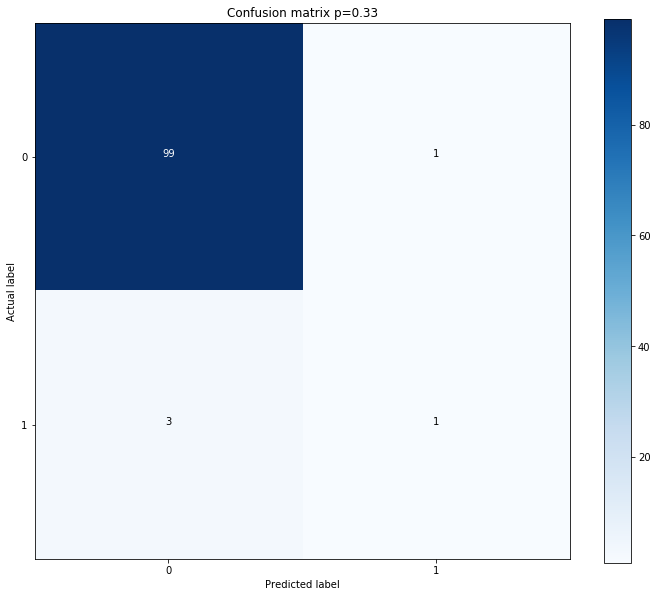

In [29]:
import pandas as pd
import yaml
import os
import datetime
import random
import dill
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.summary as tf_summary
from imblearn.over_sampling import RandomOverSampler
from math import ceil
from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard.plugins.hparams import api as hp

import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),''))
print(sys.path)
# import sys
# sys.path.append("/home/pantelis/projects/ai/computer-vision/covid-cxr") # Add root dir to path variable
# print(sys.path)
# os.chdir("/home/pantelis/projects/ai/computer-vision/covid-cxr") # Set pwd to root dir to import files from src module.

from src.models.models import *
from src.visualization.visualize import *
from src.custom.metrics import F1Score
from src.data.preprocess import remove_text

def get_class_weights(histogram, class_multiplier=None):
    '''
    Computes weights for each class to be applied in the loss function during training.
    :param histogram: A list depicting the number of each item in different class
    :param class_multiplier: List of values to multiply the calculated class weights by. For further control of class weighting.
    :return: A dictionary containing weights for each class
    '''
    weights = [None] * len(histogram)
    for i in range(len(histogram)):
        weights[i] = (1.0 / len(histogram)) * sum(histogram) / histogram[i]
    class_weight = {i: weights[i] for i in range(len(histogram))}
    if class_multiplier is not None:
        class_weight = [class_weight[i] * class_multiplier[i] for i in range(len(histogram))]
    print("Class weights: ", class_weight)
    return class_weight


def random_minority_oversample(train_set):
    '''
    Oversample the minority class using the specified algorithm
    :param train_set: Training set image file names and labels
    :return: A new training set containing oversampled examples
    '''
    X_train = train_set[[x for x in train_set.columns if x != 'label']].to_numpy()
    if X_train.shape[1] == 1:
        X_train = np.expand_dims(X_train, axis=-1)
    Y_train = train_set['label'].to_numpy()
    sampler = RandomOverSampler(random_state=np.random.randint(0, high=1000))
    X_resampled, Y_resampled = sampler.fit_resample(X_train, Y_train)
    filenames = X_resampled[:, 1]     # Filename is in second column
    label_strs = X_resampled[:, 2]    # Class name is in second column
    print("Train set shape before oversampling: ", X_train.shape, " Train set shape after resampling: ", X_resampled.shape)
    train_set_resampled = pd.DataFrame({'filename': filenames, 'label': Y_resampled, 'label_str': label_strs})
    return train_set_resampled


def train_model(cfg, data, callbacks, verbose=1):
    '''
    Train a and evaluate model on given data.
    :param cfg: Project config (from config.yml)
    :param data: dict of partitioned dataset
    :param callbacks: list of callbacks for Keras model
    :param verbose: Verbosity mode to pass to model.fit_generator()
    :return: Trained model and associated performance metrics on the test set
    '''

    # If set in config file, oversample the minority class
    if cfg['TRAIN']['IMB_STRATEGY'] == 'random_oversample':
        data['TRAIN'] = random_minority_oversample(data['TRAIN'])

    # Create ImageDataGenerators
    train_img_gen = ImageDataGenerator(rotation_range=10, preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    val_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)

    # Create DataFrameIterators
    img_shape = tuple(cfg['DATA']['IMG_DIM'])
    y_col = 'label_str'
    class_mode = 'categorical'
    train_generator = train_img_gen.flow_from_dataframe(dataframe=data['TRAIN'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'],
        class_mode=class_mode, validate_filenames=False)
    val_generator = val_img_gen.flow_from_dataframe(dataframe=data['VAL'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'],
        class_mode=class_mode, validate_filenames=False)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'],
        class_mode=class_mode, validate_filenames=False, shuffle=False)

    # Save model's ordering of class indices
    dill.dump(test_generator.class_indices, open(cfg['PATHS']['OUTPUT_CLASS_INDICES'], 'wb'))

    # Apply class imbalance strategy. We have many more X-rays negative for COVID-19 than positive.
    histogram = np.bincount(np.array(train_generator.labels).astype(int))  # Get class distribution
    class_weight = None
    if cfg['TRAIN']['IMB_STRATEGY'] == 'class_weight':
        class_multiplier = cfg['TRAIN']['CLASS_MULTIPLIER']
        class_multiplier = [class_multiplier[cfg['DATA']['CLASSES'].index(c)] for c in test_generator.class_indices]
        class_weight = get_class_weights(histogram, class_multiplier)

    # Define metrics.
    covid_class_idx = test_generator.class_indices['COVID-19']   # Get index of COVID-19 class
    thresholds = 1.0 / len(cfg['DATA']['CLASSES'])      # Binary classification threshold for a class
    metrics = [CategoricalAccuracy(name='accuracy'),
               Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
               Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
               AUC(name='auc'),
               F1Score(name='f1score', thresholds=thresholds, class_id=covid_class_idx)]

    # Define the model.
    print('Training distribution: ', ['Class ' + list(test_generator.class_indices.keys())[i] + ': ' + str(histogram[i]) + '. '
           for i in range(len(histogram))])
    input_shape = cfg['DATA']['IMG_DIM'] + [3]
    num_gpus = cfg['TRAIN']['NUM_GPUS']
    if cfg['TRAIN']['MODEL_DEF'] == 'dcnn_resnet':
        model_def = dcnn_resnet
    elif cfg['TRAIN']['MODEL_DEF'] == 'resnet50v2':
        model_def = resnet50v2
    else:
        model_def = resnet101v2
    if cfg['TRAIN']['CLASS_MODE'] == 'binary':
        histogram = np.bincount(data['TRAIN']['label'].astype(int))
        output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])
        model = model_def(cfg['NN']['DCNN_BINARY'], input_shape, metrics, 2, output_bias=output_bias, gpus=num_gpus)
    else:
        n_classes = len(cfg['DATA']['CLASSES'])
        histogram = np.bincount(data['TRAIN']['label'].astype(int))
        output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])
        model = model_def(cfg['NN']['DCNN_MULTICLASS'], input_shape, metrics, n_classes, output_bias=output_bias, gpus=num_gpus)

    # Train the model.
    steps_per_epoch = ceil(train_generator.n / train_generator.batch_size)
    val_steps = ceil(val_generator.n / val_generator.batch_size)
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=cfg['TRAIN']['EPOCHS'],
                                  validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks,
                                  verbose=verbose, class_weight=class_weight)

    # Run the model on the test set and print the resulting performance metrics.
    test_results = model.evaluate(test_generator, verbose=1)
    test_metrics = {}
    test_summary_str = [['**Metric**', '**Value**']]
    for metric, value in zip(model.metrics_names, test_results):
        test_metrics[metric] = value
        print(metric, ' = ', value)
        test_summary_str.append([metric, str(value)])
    return model, test_metrics, test_generator


def multi_train(cfg, data, callbacks, base_log_dir):
    '''
    Trains a model a series of times and returns the model with the best test set metric (specified in cfg)
    :param cfg: Project config (from config.yml)
    :param data: Partitioned dataset
    :param callbacks: List of callbacks to pass to model.fit()
    :param base_log_dir: Base directory to write logs
    :return: The trained Keras model with best test set performance on the metric specified in cfg
    '''

    # Load order of metric preference
    metric_preference = cfg['TRAIN']['METRIC_PREFERENCE']
    best_metrics = dict.fromkeys(metric_preference, 0.0)
    if 'loss' in metric_preference:
        best_metrics['loss'] = 100000.0

    # Train NUM_RUNS models and return the best one according to the preferred metrics
    for i in range(cfg['TRAIN']['NUM_RUNS']):
        print("Training run ", i+1, " / ", cfg['TRAIN']['NUM_RUNS'])
        cur_callbacks = callbacks.copy()
        cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        if base_log_dir is not None:
            log_dir = base_log_dir + cur_date
            cur_callbacks.append(TensorBoard(log_dir=log_dir, histogram_freq=1))

        # Train the model and evaluate performance on test set
        new_model, test_metrics, test_generator = train_model(cfg, data, cur_callbacks, verbose=1)

        # Log test set results and images
        if base_log_dir is not None:
            log_test_results(cfg, new_model, test_generator, test_metrics, log_dir)

        # If this model outperforms the previous ones based on the specified metric preferences, save this one.
        for i in range(len(metric_preference)):
            if (((metric_preference[i] == 'loss') and (test_metrics[metric_preference[i]] < best_metrics[metric_preference[i]]))
                    or ((metric_preference[i] != 'loss') and (test_metrics[metric_preference[i]] > best_metrics[metric_preference[i]]))):
                best_model = new_model
                best_metrics = test_metrics
                best_generator = test_generator
                best_model_date = cur_date
                break
            elif (test_metrics[metric_preference[i]] == best_metrics[metric_preference[i]]):
                continue
            else:
                break

    print("Best model test metrics: ", best_metrics)
    return best_model, best_metrics, best_generator, best_model_date


def random_hparam_search(cfg, data, callbacks, log_dir):
    '''
    Conduct a random hyperparameter search over the ranges given for the hyperparameters in config.yml and log results
    in TensorBoard. Model is trained x times for y random combinations of hyperparameters.
    :param cfg: Project config
    :param data: Dict containing the partitioned datasets
    :param callbacks: List of callbacks for Keras model (excluding TensorBoard)
    :param log_dir: Base directory in which to store logs
    :return: (Last model trained, resultant test set metrics, test data generator)
    '''

    # Define HParam objects for each hyperparameter we wish to tune.
    hp_ranges = cfg['HP_SEARCH']['RANGES']
    HPARAMS = []
    HPARAMS.append(hp.HParam('KERNEL_SIZE', hp.Discrete(hp_ranges['KERNEL_SIZE'])))
    HPARAMS.append(hp.HParam('MAXPOOL_SIZE', hp.Discrete(hp_ranges['MAXPOOL_SIZE'])))
    HPARAMS.append(hp.HParam('INIT_FILTERS', hp.Discrete(hp_ranges['INIT_FILTERS'])))
    HPARAMS.append(hp.HParam('FILTER_EXP_BASE', hp.IntInterval(hp_ranges['FILTER_EXP_BASE'][0], hp_ranges['FILTER_EXP_BASE'][1])))
    HPARAMS.append(hp.HParam('NODES_DENSE0', hp.Discrete(hp_ranges['NODES_DENSE0'])))
    HPARAMS.append(hp.HParam('CONV_BLOCKS', hp.IntInterval(hp_ranges['CONV_BLOCKS'][0], hp_ranges['CONV_BLOCKS'][1])))
    HPARAMS.append(hp.HParam('DROPOUT', hp.Discrete(hp_ranges['DROPOUT'])))
    HPARAMS.append(hp.HParam('LR', hp.RealInterval(hp_ranges['LR'][0], hp_ranges['LR'][1])))
    HPARAMS.append(hp.HParam('OPTIMIZER', hp.Discrete(hp_ranges['OPTIMIZER'])))
    HPARAMS.append(hp.HParam('L2_LAMBDA', hp.Discrete(hp_ranges['L2_LAMBDA'])))
    HPARAMS.append(hp.HParam('BATCH_SIZE', hp.Discrete(hp_ranges['BATCH_SIZE'])))
    HPARAMS.append(hp.HParam('IMB_STRATEGY', hp.Discrete(hp_ranges['IMB_STRATEGY'])))

    # Define test set metrics that we wish to log to TensorBoard for each training run
    HP_METRICS = [hp.Metric(metric, display_name='Test ' + metric) for metric in cfg['HP_SEARCH']['METRICS']]

    # Configure TensorBoard to log the results
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams_config(hparams=HPARAMS, metrics=HP_METRICS)

    # Complete a number of training runs at different hparam values and log the results.
    repeats_per_combo = cfg['HP_SEARCH']['REPEATS']   # Number of times to train the model per combination of hparams
    num_combos = cfg['HP_SEARCH']['COMBINATIONS']     # Number of random combinations of hparams to attempt
    num_sessions = num_combos * repeats_per_combo       # Total number of runs in this experiment
    model_type = 'DCNN_BINARY' if cfg['TRAIN']['CLASS_MODE'] == 'binary' else 'DCNN_MULTICLASS'
    trial_id = 0
    for group_idx in range(num_combos):
        rand = random.Random()
        HPARAMS = {h: h.domain.sample_uniform(rand) for h in HPARAMS}
        hparams = {h.name: HPARAMS[h] for h in HPARAMS}  # To pass to model definition
        for repeat_idx in range(repeats_per_combo):
            trial_id += 1
            print("Running training session %d/%d" % (trial_id, num_sessions))
            print("Hparam values: ", {h.name: HPARAMS[h] for h in HPARAMS})
            trial_logdir = os.path.join(log_dir, str(trial_id))     # Need specific logdir for each trial
            callbacks_hp = callbacks + [TensorBoard(log_dir=trial_logdir, profile_batch=0, write_graph=False)]

            # Set values of hyperparameters for this run in config file.
            for h in hparams:
                if h in ['LR', 'L2_LAMBDA']:
                    val = 10 ** hparams[h]      # These hyperparameters are sampled on the log scale.
                else:
                    val = hparams[h]
                cfg['NN'][model_type][h] = val

            # Set some hyperparameters that are not specified in model definition.
            cfg['TRAIN']['BATCH_SIZE'] = hparams['BATCH_SIZE']
            cfg['TRAIN']['IMB_STRATEGY'] = hparams['IMB_STRATEGY']

            # Run a training session and log the performance metrics on the test set to HParams dashboard in TensorBoard
            with tf.summary.create_file_writer(trial_logdir).as_default():
                hp.hparams(HPARAMS, trial_id=str(trial_id))
                model, test_metrics, test_generator = train_model(cfg, data, callbacks_hp, verbose=0)
                for metric in HP_METRICS:
                    if metric._tag in test_metrics:
                        tf.summary.scalar(metric._tag, test_metrics[metric._tag], step=1)   # Log test metric
    return


def log_test_results(cfg, model, test_generator, test_metrics, log_dir):
    '''
    Visualize performance of a trained model on the test set. Optionally save the model.
    :param cfg: Project config
    :param model: A trained Keras model
    :param test_generator: A Keras generator for the test set
    :param test_metrics: Dict of test set performance metrics
    :param log_dir: Path to write TensorBoard logs
    '''

    # Visualization of test results
    test_predictions = model.predict(test_generator, verbose=0)
    test_labels = test_generator.labels
    covid_idx = test_generator.class_indices['COVID-19']
    plt = plot_roc("Test set", test_labels, test_predictions, class_id=covid_idx)
    roc_img = plot_to_tensor()
    plt = plot_confusion_matrix(test_labels, test_predictions, class_id=covid_idx)
    cm_img = plot_to_tensor()

    # Log test set results and plots in TensorBoard
    writer = tf_summary.create_file_writer(logdir=log_dir)

    # Create table of test set metrics
    test_summary_str = [['**Metric**','**Value**']]
    thresholds = cfg['TRAIN']['THRESHOLDS']  # Load classification thresholds
    for metric in test_metrics:
        if metric in ['precision', 'recall'] and isinstance(metric, list):
            metric_values = dict(zip(thresholds, test_metrics[metric]))
        else:
            metric_values = test_metrics[metric]
        test_summary_str.append([metric, str(metric_values)])

    # Create table of model and train config values
    hparam_summary_str = [['**Variable**', '**Value**']]
    for key in cfg['TRAIN']:
        hparam_summary_str.append([key, str(cfg['TRAIN'][key])])
    if cfg['TRAIN']['CLASS_MODE'] == 'binary':
        for key in cfg['NN']['DCNN_BINARY']:
            hparam_summary_str.append([key, str(cfg['NN']['DCNN_BINARY'][key])])
    else:
        for key in cfg['NN']['DCNN_BINARY']:
            hparam_summary_str.append([key, str(cfg['NN']['DCNN_BINARY'][key])])

    # Write to TensorBoard logs
    with writer.as_default():
        tf_summary.text(name='Test set metrics', data=tf.convert_to_tensor(test_summary_str), step=0)
        tf_summary.text(name='Run hyperparameters', data=tf.convert_to_tensor(hparam_summary_str), step=0)
        tf_summary.image(name='ROC Curve (Test Set)', data=roc_img, step=0)
        tf_summary.image(name='Confusion Matrix (Test Set)', data=cm_img, step=0)
    return

def train_experiment(cfg=None, experiment='single_train', save_weights=True, write_logs=True):
    '''
    Defines and trains HIFIS-v2 model. Prints and logs relevant metrics.
    :param experiment: The type of training experiment. Choices are {'single_train'}
    :param save_weights: A flag indicating whether to save the model weights
    :param write_logs: A flag indicating whether to write TensorBoard logs
    :return: A dictionary of metrics on the test set
    '''

    # Load project config data
    if cfg is None:
        cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))

    # Set logs directory
    cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    log_dir = cfg['PATHS']['LOGS'] + "training/" + cur_date if write_logs else None
    if not os.path.exists(cfg['PATHS']['LOGS'] + "training/"):
        os.makedirs(cfg['PATHS']['LOGS'] + "training/")

    # Load dataset file paths and labels
    data = {}
    data['TRAIN'] = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
    data['VAL'] = pd.read_csv(cfg['PATHS']['VAL_SET'])
    data['TEST'] = pd.read_csv(cfg['PATHS']['TEST_SET'])

    # Set callbacks.
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=cfg['TRAIN']['PATIENCE'], mode='min', restore_best_weights=True)
    callbacks = [early_stopping]

    # Conduct the desired train experiment
    if experiment == 'hparam_search':
        log_dir = cfg['PATHS']['LOGS'] + "hparam_search/" + cur_date
        random_hparam_search(cfg, data, callbacks, log_dir)
    else:
        if experiment == 'multi_train':
            base_log_dir = cfg['PATHS']['LOGS'] + "training/" if write_logs else None
            model, test_metrics, test_generator, cur_date = multi_train(cfg, data, callbacks, base_log_dir)
        else:
            if write_logs:
                tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
                callbacks.append(tensorboard)
            model, test_metrics, test_generator = train_model(cfg, data, callbacks)
            if write_logs:
                log_test_results(cfg, model, test_generator, test_metrics, log_dir)
        if save_weights:
            model_path = cfg['PATHS']['MODEL_WEIGHTS'] + 'model' + cur_date + '.h5'
            save_model(model, model_path)  # Save the model's weights
    return


if __name__ == '__main__':
    cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    train_experiment(cfg=cfg, experiment=cfg['TRAIN']['EXPERIMENT_TYPE'], save_weights=True, write_logs=True)

Found 104 non-validated image filenames belonging to 3 classes.


Intercept 6.747726927826166e-08
Prediction_local [3.12586221e-08]
Right: 4.426867e-09
Intercept 0.1827402751233097
Prediction_local [0.17667777]
Right: 0.15621541
Intercept 0.8172596456568738
Prediction_local [0.82332222]
Right: 0.84378463
Explanation time = 9.388135 seconds


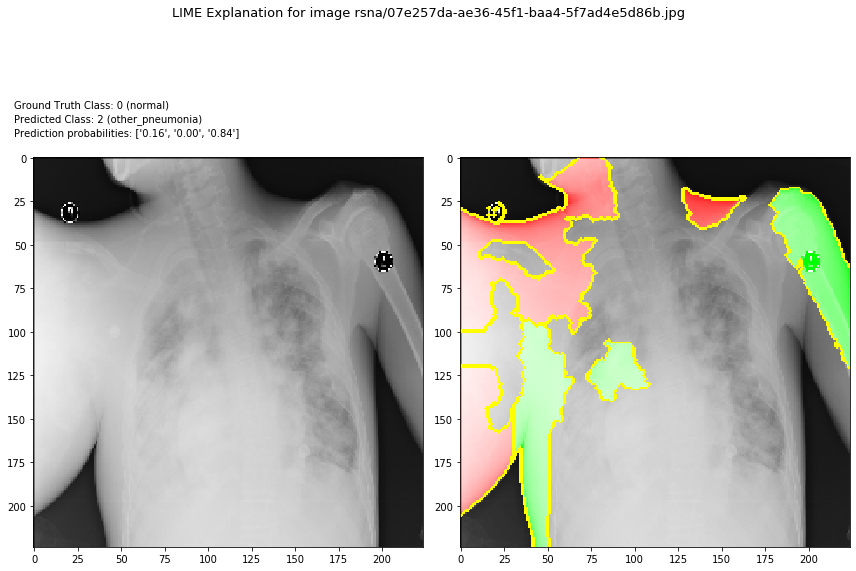

In [30]:
from lime.lime_image import *
import pandas as pd
import yaml
import os
import datetime
import dill
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'../'))

from src.visualization.visualize import visualize_explanation
from src.predict import predict_instance, predict_and_explain
from src.data.preprocess import remove_text


def setup_lime():
    '''
    Load relevant information and create a LIME Explainer
    :return: dict containing important information and objects for explanation experiments
    '''

    # Load relevant constants from project config file
    cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    lime_dict = {}
    lime_dict['NUM_SAMPLES'] = cfg['LIME']['NUM_SAMPLES']
    lime_dict['NUM_FEATURES'] = cfg['LIME']['NUM_FEATURES']
    lime_dict['IMG_PATH'] = cfg['PATHS']['IMAGES']
    lime_dict['RAW_DATA_PATH'] = cfg['PATHS']['RAW_DATA']
    lime_dict['IMG_DIM'] = cfg['DATA']['IMG_DIM']
    lime_dict['PRED_THRESHOLD'] = cfg['PREDICTION']['THRESHOLD']
    lime_dict['CLASSES'] = cfg['DATA']['CLASSES']
    lime_dict['CLASS_MODE'] = cfg['TRAIN']['CLASS_MODE']
    lime_dict['COVID_ONLY'] = cfg['LIME']['COVID_ONLY']
    KERNEL_WIDTH = cfg['LIME']['KERNEL_WIDTH']
    FEATURE_SELECTION = cfg['LIME']['FEATURE_SELECTION']

    # Load train and test sets
    lime_dict['TRAIN_SET'] = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
    lime_dict['TEST_SET'] = pd.read_csv(cfg['PATHS']['TEST_SET'])

    # Create ImageDataGenerator for test set
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=lime_dict['TEST_SET'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col='label_str', target_size=tuple(cfg['DATA']['IMG_DIM']), batch_size=1,
        class_mode='categorical', validate_filenames=False, shuffle=False)
    lime_dict['TEST_GENERATOR'] = test_generator

    # Define the LIME explainer
    lime_dict['EXPLAINER'] = LimeImageExplainer(kernel_width=KERNEL_WIDTH, feature_selection=FEATURE_SELECTION,
                                                verbose=True)
    dill.dump(lime_dict['EXPLAINER'], open(cfg['PATHS']['LIME_EXPLAINER'], 'wb'))    # Serialize the explainer

    # Load trained model's weights
    lime_dict['MODEL'] = load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)

    return lime_dict


def explain_xray(lime_dict, idx, save_exp=True):
    '''
    Make a prediction and provide a LIME explanation
    :param lime_dict: dict containing important information and objects for explanation experiments
    :param idx: index of image in test set to explain
    :param save_exp: Boolean indicating whether to save the explanation visualization
    '''

    # Get i'th preprocessed image in test set
    lime_dict['TEST_GENERATOR'].reset()
    for i in range(idx + 1):
        x, y = lime_dict['TEST_GENERATOR'].next()
    x = np.squeeze(x, axis=0)

    # Get the corresponding original image (no preprocessing)
    orig_img = cv2.imread(lime_dict['RAW_DATA_PATH'] + lime_dict['TEST_SET']['filename'][idx])
    new_dim = tuple(lime_dict['IMG_DIM'])
    orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

    # Make a prediction for this image and retrieve a LIME explanation for the prediction
    start_time = datetime.datetime.now()
    explanation, probs = predict_and_explain(x, lime_dict['MODEL'], lime_dict['EXPLAINER'],
                                      lime_dict['NUM_FEATURES'], lime_dict['NUM_SAMPLES'])
    print("Explanation time = " + str((datetime.datetime.now() - start_time).total_seconds()) + " seconds")


    # Get image filename and label
    img_filename = lime_dict['TEST_SET']['filename'][idx]
    label = lime_dict['TEST_SET']['label'][idx]

    # Rearrange prediction probability vector to reflect original ordering of classes in project config
    probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_dict['TEST_GENERATOR'].class_indices]

    # Visualize the LIME explanation and optionally save it to disk
    if save_exp:
        file_path = lime_dict['IMG_PATH']
    else:
        file_path = None
    if lime_dict['COVID_ONLY'] == True:
        label_to_see = lime_dict['TEST_GENERATOR'].class_indices['COVID-19']
    else:
        label_to_see = 'top'
    _ = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see,
                          dir_path=file_path)
    return


if __name__ == '__main__':
    lime_dict = setup_lime()
    i = 48                                                       # Select i'th image in test set
    explain_xray(lime_dict, i, save_exp=True)                   # Generate explanation for image

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0 (Conv2D)                (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv0_0[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

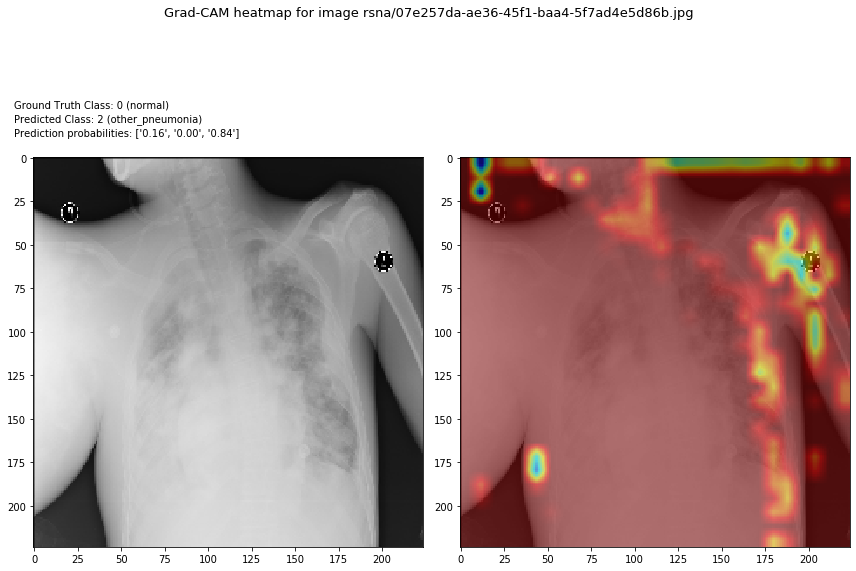

In [31]:
import yaml
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from src.data.preprocess import remove_text
from src.predict import predict_instance
from src.visualization.visualize import visualize_heatmap

def setup_gradcam():
    '''
    Load relevant variables to apply Grad-CAM
    :return: dict containing important information and objects for Grad-CAM visualizations
    '''

    cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    setup_dict = {}

    setup_dict['MODEL'] = load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)
    setup_dict['MODEL'].summary()

    # Get name of final convolutional layer
    layer_name = ''
    for layer in setup_dict['MODEL'].layers:
        if any('Conv2D' in l for l in layer._keras_api_names):
            layer_name = layer.name
    setup_dict['LAYER_NAME'] = layer_name

    setup_dict['IMG_PATH'] = cfg['PATHS']['IMAGES']
    setup_dict['RAW_DATA_PATH'] = cfg['PATHS']['RAW_DATA']
    setup_dict['TEST_SET'] = pd.read_csv(cfg['PATHS']['TEST_SET'])
    setup_dict['IMG_DIM'] = cfg['DATA']['IMG_DIM']
    setup_dict['CLASSES'] = cfg['DATA']['CLASSES']

    # Create ImageDataGenerator for test set
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=setup_dict['TEST_SET'],
                                                      directory=cfg['PATHS']['RAW_DATA'],
                                                      x_col="filename", y_col='label_str',
                                                      target_size=tuple(cfg['DATA']['IMG_DIM']), batch_size=1,
                                                      class_mode='categorical', validate_filenames=False, shuffle=False)
    setup_dict['TEST_GENERATOR'] = test_generator
    return setup_dict

def apply_gradcam(setup_dict, idx, hm_intensity=0.5, save_hm=True):
    '''
    Make a prediction and overlay a heatmap depicting the gradient of the predicted class with respect to the output of
    a layer of the model.
    :param setup_dict: dict containing important information and objects for Grad-CAM
    :param idx: index of image in test set to explain
    :param save_hm: Boolean indicating whether to save the heatmap visualization
    '''

    # Get i'th preprocessed image in test set
    setup_dict['TEST_GENERATOR'].reset()
    for i in range(idx + 1):
        x, y = setup_dict['TEST_GENERATOR'].next()

    # Get the corresponding original image (no preprocessing)
    orig_img = cv2.imread(setup_dict['RAW_DATA_PATH'] + setup_dict['TEST_SET']['filename'][idx])
    new_dim = tuple(setup_dict['IMG_DIM'])
    orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

    # Predict this example
    probs = predict_instance(x, setup_dict['MODEL'])

    # Rearrange prediction probability vector to reflect original ordering of classes in project config
    probs = [probs[0][setup_dict['CLASSES'].index(c)] for c in setup_dict['TEST_GENERATOR'].class_indices]

    with tf.GradientTape() as tape:
        last_conv_layer = setup_dict['MODEL'].get_layer(setup_dict['LAYER_NAME'])
        iterate = Model([setup_dict['MODEL'].inputs], [setup_dict['MODEL'].output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0.0)    # Equivalent of passing through ReLU
    heatmap /= np.max(heatmap)
    heatmap = heatmap.squeeze(axis=0)
    heatmap = cv2.resize(heatmap, tuple(setup_dict['IMG_DIM']))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_img = cv2.addWeighted(heatmap, hm_intensity, orig_img, 1.0 - hm_intensity, 0)

    # Visualize the Grad-CAM heatmap and optionally save it to disk
    if save_hm:
        file_path = setup_dict['IMG_PATH']
    else:
        file_path = None
    img_filename = setup_dict['TEST_SET']['filename'][idx]
    label = setup_dict['TEST_SET']['label'][idx]
    _ = visualize_heatmap(orig_img, heatmap_img, img_filename, label, probs, setup_dict['CLASSES'],
                              dir_path=file_path)
    return heatmap

if __name__ == '__main__':
    setup_dict = setup_gradcam()
    i = 48
    heatmap = apply_gradcam(setup_dict, i, hm_intensity=0.5, save_hm=True)    # Generate heatmap for image

In [34]:
!tensorboard dev upload --logdir ./results/logstraining/20201122-175713\
  --name "Explainability Binary CLass" \
  --description "Training with 10 Epoch" \
  --one_shot

2020-11-22 19:16:59.046727: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.

View your TensorBoard live at: https://tensorboard.dev/experiment/0f9f4f73Sgmbpm7be9Lg1w/

[2020-11-22T19:17:01] Uploader started.
[2020-11-22T19:17:10] Total uploaded: 540 scalars, 2343 tensors (1.7 MB), 1 binary objects (492.0 kB)
Listening for new data in logdir...
Done. View your TensorBoard at https://tensorboard.dev/experiment/0f9f4f73Sgmbpm7be9Lg1w/
